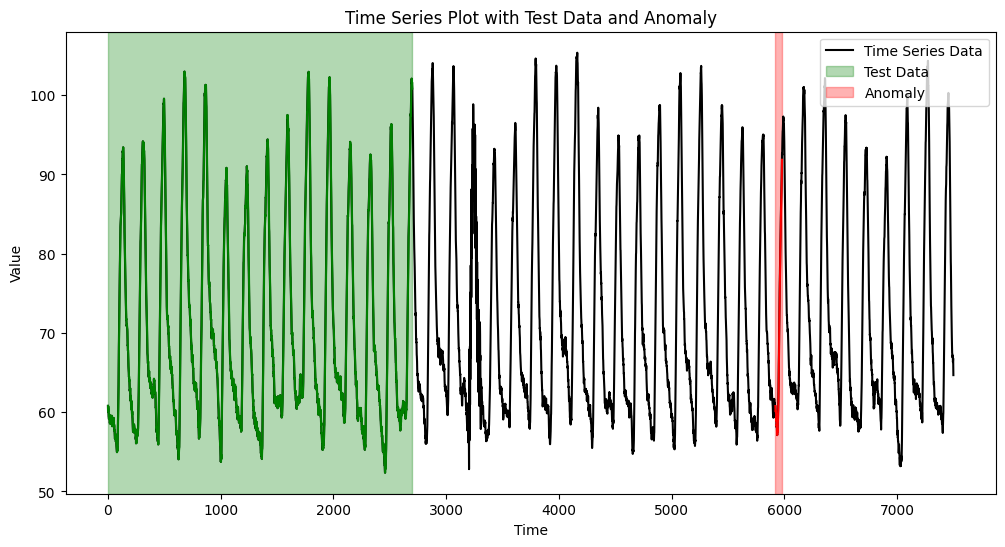

In [23]:
import matplotlib.pyplot as plt

# Define the path to your data file
file_path = './UCR_Anomaly/028_UCR_Anomaly_DISTORTEDInternalBleeding17_1600_3198_3309.txt'

# Function to read time series data from a file
def read_time_series(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Convert each line to a float
    return [float(line.strip()) for line in lines]

# Read the time series data
time_series = read_time_series(file_path)

# Define the ranges for test data and anomaly
test_data_range = range(1, 2701)  # 1 to 2700
anomaly_range = range(5920, 5980)  # 5920 to 5979

# Plotting the time series data
plt.figure(figsize=(12, 6))

# Plot all data as a base in black
plt.plot(time_series, label="Time Series Data", color='black')

# Marking the test data range with a green vertical bar
plt.axvspan(test_data_range[0], test_data_range[-1], color='green', alpha=0.3, label='Test Data')

# Marking the anomaly range with a red vertical bar
plt.axvspan(anomaly_range[0], anomaly_range[-1], color='red', alpha=0.3, label='Anomaly')

# Highlight test data in green
plt.plot(test_data_range, time_series[:len(test_data_range)], color='green')

# Highlight anomaly in red
plt.plot(anomaly_range, time_series[5919:5979], color='red')

# Add titles and labels
plt.title('Time Series Plot with Test Data and Anomaly')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()


In [24]:
import numpy as np

# Parse Filename and Extract Information
def parse_filename(filename):
    parts = filename.split('_')
    dataset_number = parts[0]
    mnemonic_name = parts[3]
    train_data_end = int(parts[4]) # End of training data index
    anomaly_start = int(parts[5]) # Start of anomaly
    anomaly_end = int(parts[6]) # End of anomaly
    
    return dataset_number, mnemonic_name, train_data_end, anomaly_start, anomaly_end

# Function to Load and Split Data
def load_and_split_data(filepath):
    # Parse the file name
    filename = file_path.split('/')[-1].replace('.txt', '')
    _, _, train_data_end, _, _ = parse_filename(filename)
    
    # Load the data from the text file
    data = np.loadtxt(filepath)
    
    train_data = data[:train_data_end]
    test_data = data[train_data_end:]
    
    return train_data, test_data

# Load and Split the data
train_data, test_data = load_and_split_data(file_path)

print("Training Data: ")
print(train_data)

print("\nTest Data: ")
print(test_data)

Training Data: 
[60.797027 60.084413 60.736853 ... 96.232181 95.466318 95.467059]

Test Data: 
[95.769905 94.671558 93.687582 ... 66.790278 65.295877 64.677737]


In [25]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

In [26]:
def creat_sliding_windows(data, windows_size):
    sequences = []
    for i in range(len(data) - windows_size):
        seq = data[i:i+windows_size]
        sequences.append(seq)
    return np.array(sequences)

In [27]:
class ClassicalGenerator(nn.Module):
    def __init__(self, input_size, hiddem_dim, output_size):
        super(ClassicalGenerator, self).__init__()
        self.hidden_layer_size = 127
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hiddem_dim, batch_first=True)
        
        # Define output layer
        self.linear = nn.Linear(hiddem_dim, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:,-1])
        
        return predictions


In [28]:
# Normalize data
train_data_normalized = (train_data - np.mean(train_data)) / np.std(train_data)
    
# Create sliding windows
window_size = 128
sequences = creat_sliding_windows(train_data, window_size)

# Convert sequences to PyTorch variables
sequences = Variable(torch.FloatTensor(sequences))


In [29]:
# Instantiate the Model and Define Loss/Optimizer
input_size = 1
hidden_dim = 64
output_size = 1

model = ClassicalGenerator(input_size, hidden_dim, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [30]:
# Train the Model
epochs = 100
for epoch in range(epochs):
    for seq in sequences:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq[:-1].view(-1, 1,1))
        
        single_loss = loss_function(y_pred, seq[-1])
        single_loss.backward()
        optimizer.step()
        
    if epoch%10 == 1:
        print(f'Epoch {epoch} loss: {single_loss.item()}')

Epoch 1 loss: 666.437744140625
Epoch 11 loss: 642.2582397460938
Epoch 21 loss: 642.2583618164062
Epoch 31 loss: 642.2583618164062
Epoch 41 loss: 642.2583618164062
Epoch 51 loss: 642.2583618164062
Epoch 61 loss: 642.2583618164062
Epoch 71 loss: 642.2583618164062
Epoch 81 loss: 642.2583618164062
Epoch 91 loss: 642.2583618164062


In [32]:
torch.save(model.state_dict(), 'classical_generator_model.pth')